In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/Users/michaelkatz/Research/Eryn/')

from eryn.ensemble import EnsembleSampler
from eryn.state import State
from eryn.prior import PriorContainer, uniform_dist
from eryn.utils import TransformContainer
from eryn.moves import GaussianMove
from eryn.utils.utility import groups_from_inds

import matplotlib.pyplot as plt
import numpy as np

# set random seed
np.random.seed(42)

import corner


# Getting Started with Eryn

## n-dimensional Gaussian

Let's start by running on a simple Gaussian likelihood. We will then build up to the full capabilities of the Eryn sampler. 

In [9]:
# Gaussian likelihood
def log_prob_fn(x, mu, invcov):
    diff = x - mu
    return -0.5 * (diff * np.dot(invcov, diff.T).T).sum()


 10%|████▎                                    | 26/250 [00:00<00:00, 253.86it/s]

[-16.16671779 -14.50232889 -13.09743252 -34.30457911 -25.28345897
 -26.34655604 -31.13664537 -20.92341842 -34.69756728  -6.44769269
 -19.91377305 -20.97328238 -15.18287525 -23.24121394 -33.10446958
  -5.84347286 -17.5000512  -22.1974943  -21.19066856 -34.86285916
 -24.25305212 -22.16291275 -17.13638015 -23.93461502 -21.91819141
 -21.42451172 -10.9306566  -13.1367641  -32.6320937  -30.55058014
 -20.76047385 -12.07819405 -28.82055467 -21.15965766  -9.25209614
 -14.3576125  -25.97679259 -17.83841101 -14.71188489 -24.30854931
 -30.87751653 -34.81697388 -23.97455623  -7.29857103 -11.88590218
 -15.24023652 -30.86452817 -17.16567704 -12.3642469  -32.99418917
 -34.87807945 -11.47499079 -42.36259277 -14.06439071 -17.77130029
 -11.59343251 -29.0369608  -14.95456827 -14.67162181 -27.96487644
  -3.60315631 -34.87909215 -18.53110128 -19.04846884 -27.24416437
 -23.26839951 -20.75782125 -27.22791042 -37.10112055 -17.49317686
 -18.83683764 -16.06545977  -8.37013165 -30.15634298 -13.59464156
 -30.00815

100%|████████████████████████████████████████| 250/250 [00:00<00:00, 252.47it/s]


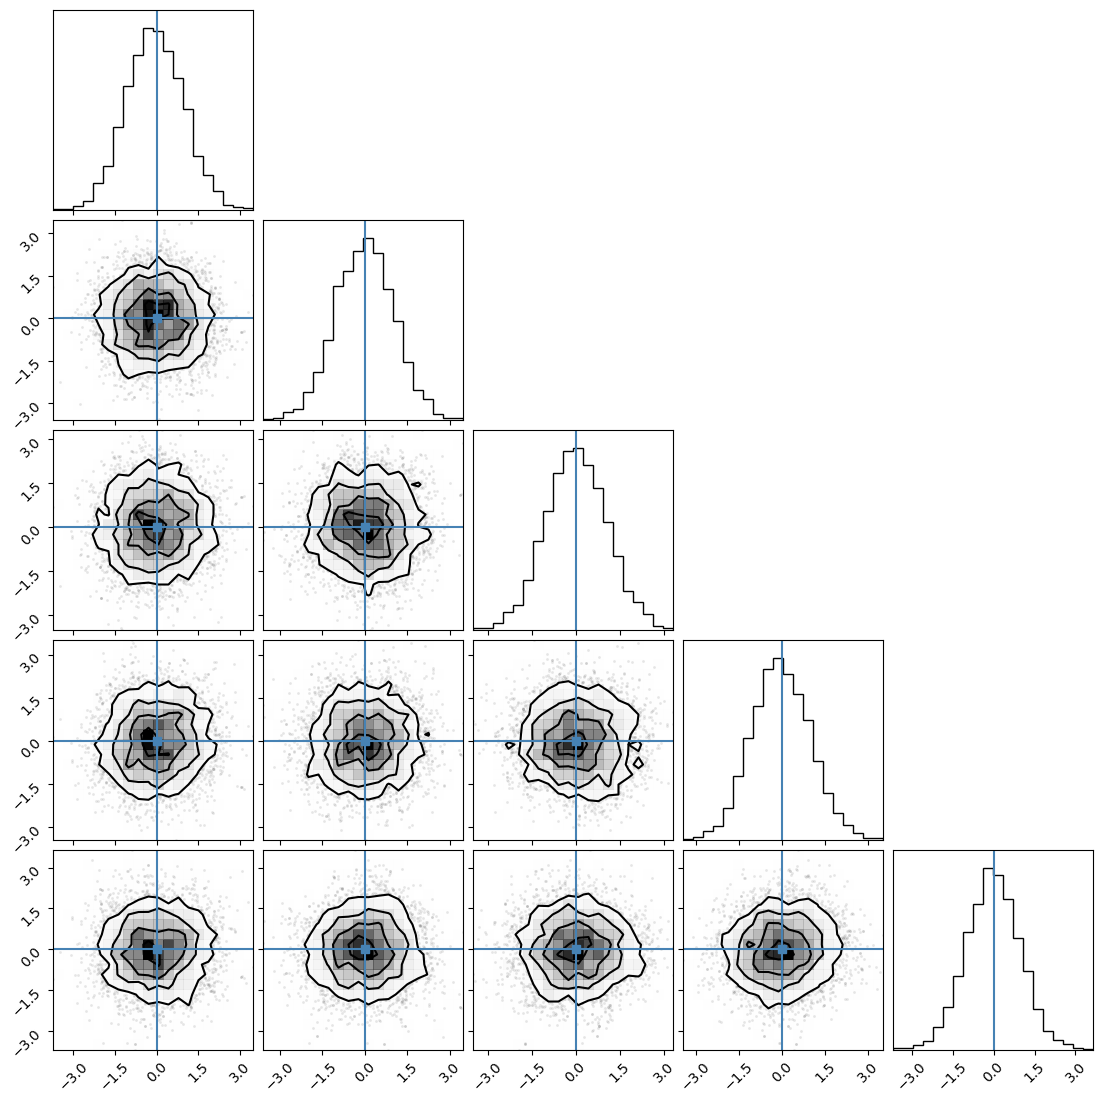

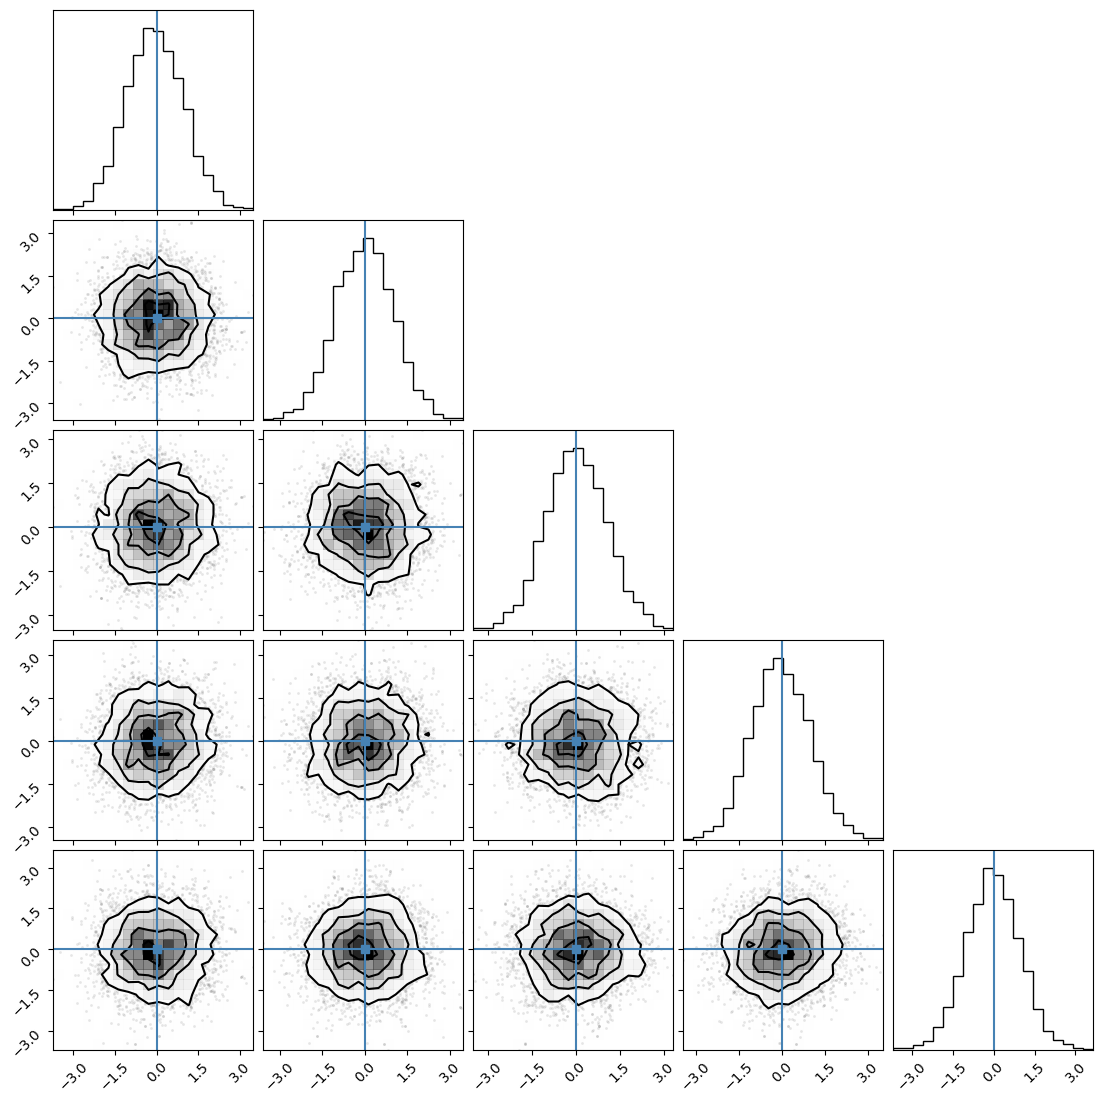

In [10]:
ndim = 5
nwalkers = 100

# mean
means = np.zeros(ndim)  # np.random.rand(ndim)

# define covariance matrix
cov = np.diag(np.ones(ndim))
invcov = np.linalg.inv(cov)

# set prior limits
lims = 5.0
priors_in = {i: uniform_dist(-lims, lims) for i in range(ndim)}
priors = PriorContainer(priors_in)

# starting positions
# randomize throughout prior
coords = priors.rvs(size=(nwalkers,))

# check log_prob
log_prob = np.asarray([
    log_prob_fn(coords[i], means, invcov)
for i in range(nwalkers)])
print(log_prob)
breakpoint()
ensemble = EnsembleSampler(
    nwalkers,
    ndim,
    log_prob_fn,
    priors,
    args=[means, invcov],
    vectorize=False,
)

nsteps = 50
# burn for 1000 steps
burn = 10
# thin by 5
thin_by = 5
out = ensemble.run_mcmc(coords, nsteps, burn=burn, progress=True, thin_by=thin_by)

samples = ensemble.get_chain()['model_0'].reshape(-1, ndim)
corner.corner(samples, truths=np.full(ndim, 0.0))

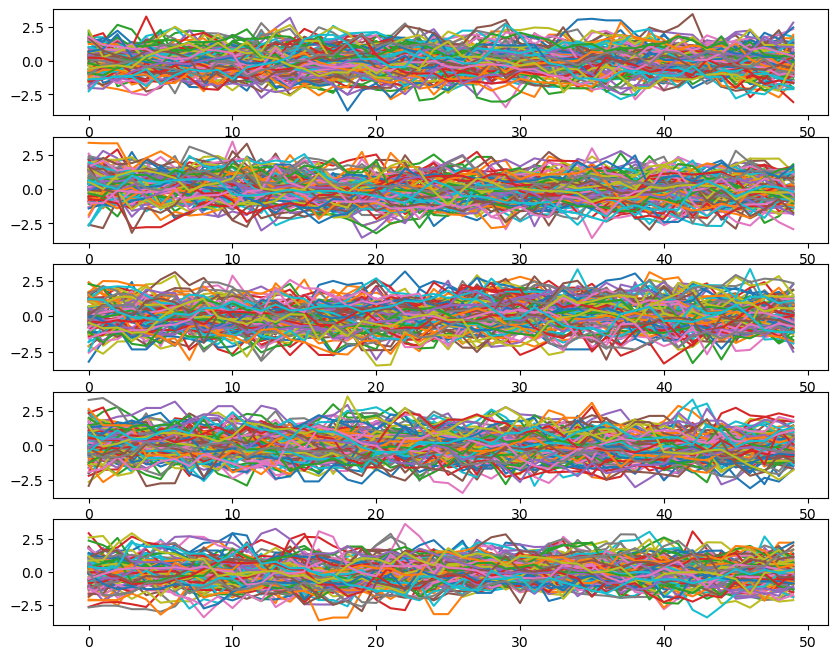

In [11]:
#### Chains
fig, ax = plt.subplots(ndim, 1)
fig.set_size_inches(10, 8)
for i in range(ndim):
    for walk in range(nwalkers):
        ax[i].plot(ensemble.get_chain()['model_0'][:, 0, walk, :, i])

## Add tempering

In [12]:

ndim = 5
nwalkers = 100
ntemps = 10

tempering_kwargs=dict(ntemps=ntemps)

# randomize throughout prior
coords = priors.rvs(size=(ntemps, nwalkers,))

ensemble_pt = EnsembleSampler(
    nwalkers,
    ndim,
    log_prob_fn,
    priors,
    args=[means, cov],
    tempering_kwargs=tempering_kwargs
)

nsteps = 5000
# burn for 1000 steps
burn = 1000
# thin by 5
thin_by = 5
ensemble_pt.run_mcmc(coords, nsteps, burn=burn, progress=True, thin_by=thin_by)



TypeError: __call__() takes 2 positional arguments but 3 were given

In [ ]:
for temp in range(ntemps):
    print(temp + 1)
    samples = ensemble_pt.get_chain()['model_0'][:, temp].reshape(-1, ndim)
    corner.corner(samples, truths=np.full(ndim, 0.0))

In [ ]:
#### Chains
for temp in range(ntemps):
    fig, ax = plt.subplots(ndim, 1)
    fig.set_size_inches(10, 8)
    for i in range(ndim):
        for walk in range(nwalkers):
            ax[i].plot(ensemble_pt.get_chain()['model_0'][:, temp, walk, :, i])

## Add multiple leaf count uncertainty (i.e. reversible-jump MCMC))

In [ ]:
# need new likelihood
def gaussian(x, a, b, c):
    f_x = a[:, None] * np.exp(-((x[None, :] - b[:, None]) ** 2) / (2 * c[:, None] ** 2))
    return f_x


def gaussian_flat(x, a, b, c):
    f_x = a * np.exp(-((x - b) ** 2) / (2 * c ** 2))
    return f_x

def combine_gaussians(x1, group1, t):
    a = x1[:, 0]
    b = x1[:, 1]
    c = x1[:, 2]

    gauss_out = gaussian(t, a, b, c)

    num_groups = group1.max() + 1

    # add templates to the proper template based on group1
    template = np.zeros((num_groups, len(t)))
    for i in range(num_groups):
        inds1 = np.where(group1 == i)

        template[i] += gauss_out[inds1].sum(axis=0)
    return template

def log_prob_fn(x1, group1, t, data, sigma):
    # x1 is one leaf's parameters
    # group1 is which tree this leaf belongs to

   
    template = combine_gaussians(x1, group1, t)

        
    ll = - 0.5 * np.sum(((template - data) / sigma) ** 2, axis=-1)
    return ll


nwalkers = 20
ntemps = 4
ndims = [3]
nleaves_max = [8]

branch_names = ["gauss"]

# define time stream
num = 500
t = np.linspace(-1, 1, num)

gauss_inj_params = [
    [3.3, -0.2, 0.1],
    [2.6, -0.1, 0.1],
    [3.4, 0.0, 0.1],
    [2.9, 0.3, 0.1],
]

injection = np.zeros(num)

# combine gaussians
injection = combine_gaussians(np.asarray(gauss_inj_params), np.zeros(len(gauss_inj_params), dtype=int), t)[0]

# set noise level
sigma = 0.25
y = injection + sigma * np.random.randn(len(injection))

import matplotlib.pyplot as plt

plt.plot(t, y, label="data", color="lightskyblue")
plt.plot(t, injection, label="injection", color="crimson")
plt.legend()

#### setup for reversible-jump

In [ ]:
# describes priors for all leaves independently
priors = {
    "gauss": {
        0: uniform_dist(2.5, 3.5),  # amplitude
        1: uniform_dist(t.min(), t.max()),  # mean 
        2: uniform_dist(0.01, 0.21),  # sigma
    },
}

coords = {
    name: np.zeros((ntemps, nwalkers, nleaf, ndim))
    for nleaf, ndim, name in zip(nleaves_max, ndims, branch_names)
}

# this is the sigma for the multivariate Gaussian that sets starting points
# We need it to be very small to assume we are passed the search phase
# we will verify this is with likelihood calculations
sig1 = 0.00000001
for nleaf, ndim, name in zip(nleaves_max, ndims, branch_names):
    for nn in range(nleaf):
        if nn >= len(gauss_inj_params):
            # fill a non-used starting leaf with reasonable parameters
            nn = np.random.randint(low=0, high=3)
        coords[name][:, :, nn] = np.random.multivariate_normal(gauss_inj_params[nn], np.diag(np.ones(3) * sig1), size=(ntemps, nwalkers))  # dist.rvs(size=(ntemps, nwalkers, nleaf))

# make sure to start near the proper setup
inds = {
     name: np.zeros((ntemps, nwalkers, nleaf), dtype=bool)
     for nleaf, name in zip(nleaves_max, branch_names)
}

inds['gauss'][:, :, :len(gauss_inj_params)] = True

coords_in = {name: coords[name][inds[name]] for name in coords}

# useful function: groups_from_inds
groups_in = groups_from_inds(inds)

log_prob = log_prob_fn(
    coords_in["gauss"],
    groups_in["gauss"],
    t,
    y,
    sigma
)

# make sure it is reasonably small
# will not be zero due to noise
log_prob = log_prob.reshape(ntemps, nwalkers)
print(log_prob)

# setup starting state

log_prob = log_prob.reshape(ntemps, nwalkers)

blobs = None  # np.random.randn(ntemps, nwalkers, 3)

state = State(coords, log_prob=log_prob, inds=inds)


In [ ]:
# for the Gaussian Move, will be explained later
factor = 0.0001
cov = {"gauss": np.diag(np.ones(ndims[0])) * factor}

moves = GaussianMove(cov)

# backend.grow(100, blobs)


ensemble = EnsembleSampler(
    nwalkers,
    ndims,  # assumes ndim_max
    log_prob_fn,
    priors,
    args=[t, y, sigma],
    tempering_kwargs=dict(ntemps=ntemps),
    nbranches=len(branch_names),
    branch_names=branch_names,
    nleaves_max=nleaves_max,
    provide_groups=True,
    moves=moves,
    rj_moves=True,  # basic generation of new leaves from the prior
)


In [ ]:
nsteps = 10000
ensemble.run_mcmc(state, nsteps, burn=1000, progress=True, thin_by=1)


In [ ]:
samples = ensemble.get_chain()['gauss'][:, 0].reshape(-1, ndim)
samples[~np.isnan(samples[:, 0])]

In [ ]:
for temp in range(ntemps):
    print(temp + 1)
    samples = ensemble.get_chain()['gauss'][:, temp].reshape(-1, ndim)
    
    # need to remove NaNs
    samples = samples[~np.isnan(samples[:, 0])]
    corner.corner(samples)

In [ ]:
print(f'max ll: {ensemble.get_log_prob().max()}')

bns = (
    np.arange(1, nleaves_max[0] + 2) - 0.5
)  # Just to make it pretty and center the bins

fig, ax = plt.subplots(ntemps, 1, sharex=True)
fig.set_size_inches(10, 8)
for temp, ax_t in enumerate(ax):
    ax_t.hist(ensemble.get_nleaves()['gauss'][:, temp].flatten(), bins=bns)
    

## Add multiple branch

In [ ]:
# need new likelihood
def gaussian(x, a, b, c):
    f_x = a[:, None] * np.exp(-((x[None, :] - b[:, None]) ** 2) / (2 * c[:, None] ** 2))
    return f_x


def gaussian_flat(x, a, b, c):
    f_x = a * np.exp(-((x - b) ** 2) / (2 * c ** 2))
    return f_x

def combine_gaussians(x1, group1, t):
    a = x1[:, 0]
    b = x1[:, 1]
    c = x1[:, 2]

    gauss_out = gaussian(t, a, b, c)

    num_groups = group1.max() + 1

    # add templates to the proper template based on group1
    template = np.zeros((num_groups, len(t)))
    for i in range(num_groups):
        inds1 = np.where(group1 == i)

        template[i] += gauss_out[inds1].sum(axis=0)
    return template

# need new likelihood
def sine(x, a, b, c):
    f_x = a[:, None] * np.sin(2 * np.pi * b[:, None] * x + c[:, None])
    return f_x


def sine_flat(x, a, b, c):
    f_x = a * np.sin(2 * np.pi * b * x + c)
    return f_x

def combine_sines(x1, group1, t):
    a = x1[:, 0]
    b = x1[:, 1]
    c = x1[:, 2]

    gauss_out = sine(t, a, b, c)

    num_groups = group1.max() + 1

    # add templates to the proper template based on group1
    template = np.zeros((num_groups, len(t)))
    for i in range(num_groups):
        inds1 = np.where(group1 == i)

        template[i] += gauss_out[inds1].sum(axis=0)
    return template

def log_prob_fn(xs, groups, t, data, sigma):
    # x1 is one leaf's parameters
    # group1 is which tree this leaf belongs to
    
    x1, x2 = xs
    group1, group2 = groups
    
    template_gaussian = combine_gaussians(x1, group1, t)
    
    template_sine = combine_sines(x2, group2, t)

    template = template_gaussian + template_sine
    
    ll = - 0.5 * np.sum(((template - data) / sigma) ** 2, axis=-1)
    return ll


nwalkers = 20
ntemps = 4
ndims = [3, 3]
nleaves_max = [8, 5]

branch_names = ["gauss", "sine"]

# define time stream
num = 500
t = np.linspace(-1, 1, num)

gauss_inj_params = [
    [3.3, -0.2, 0.1],
    [2.6, -0.1, 0.1],
    [3.4, 0.0, 0.1],
    [2.9, 0.3, 0.1],
]

sine_inj_params = [
    [1.3, 10.1, 1.0],
    [0.8, 4.6, 1.2],
]

injection = np.zeros(num)

# combine gaussians
injection = combine_gaussians(np.asarray(gauss_inj_params), np.zeros(len(gauss_inj_params), dtype=int), t)[0]
injection += combine_sines(np.asarray(sine_inj_params), np.zeros(len(sine_inj_params), dtype=int), t)[0]
# set noise level
sigma = 0.5
y = injection + sigma * np.random.randn(len(injection))

import matplotlib.pyplot as plt

plt.plot(t, y, label="data", color="lightskyblue")
plt.plot(t, injection, label="injection", color="crimson")
plt.legend()

#### setup for reversible-jump

In [ ]:
# describes priors for all leaves independently
priors = {
    "gauss": {
        0: uniform_dist(2.5, 3.5),  # amplitude
        1: uniform_dist(t.min(), t.max()),  # mean 
        2: uniform_dist(0.01, 0.21),  # sigma
    },
    "sine": {
        0: uniform_dist(0.5, 1.5),  # amplitude
        1: uniform_dist(1., 20.),  # mean 
        2: uniform_dist(0.0, 2 * np.pi),  # sigma
    },
}

coords = {
    name: np.zeros((ntemps, nwalkers, nleaf, ndim))
    for nleaf, ndim, name in zip(nleaves_max, ndims, branch_names)
}

# this is the sigma for the multivariate Gaussian that sets starting points
# We need it to be very small to assume we are passed the search phase
# we will verify this is with likelihood calculations
sig1 = 0.00000001
inj_params = {'gauss': gauss_inj_params, 'sine': sine_inj_params}
for nleaf, ndim, name in zip(nleaves_max, ndims, branch_names):
    for nn in range(nleaf):
        if nn >= len(inj_params[name]):
            # fill a non-used starting leaf with reasonable parameters
            nn = np.random.randint(low=0, high=len(inj_params[name]))

        coords[name][:, :, nn] = np.random.multivariate_normal(inj_params[name][nn], np.diag(np.ones(ndim) * sig1), size=(ntemps, nwalkers))  # dist.rvs(size=(ntemps, nwalkers, nleaf))

# make sure to start near the proper setup
inds = {
     name: np.zeros((ntemps, nwalkers, nleaf), dtype=bool)
     for nleaf, name in zip(nleaves_max, branch_names)
}

inds['gauss'][:, :, :len(gauss_inj_params)] = True
inds['sine'][:, :, :len(sine_inj_params)] = True

# setup groups just to compute likelihood
groups = {
    name: np.arange(coords[name].shape[0] * coords[name].shape[1]).reshape(
        coords[name].shape[:2]
    )[:, :, None]
    for name in coords
}

groups = {
    name: np.repeat(groups[name], coords[name].shape[2], axis=-1) for name in groups
}

coords_in = {name: coords[name][inds[name]] for name in coords}
groups_in = {name: groups[name][inds[name]] for name in groups}

log_prob = log_prob_fn(
    [coords_in["gauss"], coords_in["sine"]],
    [groups_in["gauss"], groups_in["sine"]],
    t,
    y,
    sigma
)

# make sure it is reasonably small
# will not be zero due to noise
log_prob = log_prob.reshape(ntemps, nwalkers)
print(log_prob)

# setup starting state

log_prob = log_prob.reshape(ntemps, nwalkers)

blobs = None  # np.random.randn(ntemps, nwalkers, 3)

state = State(coords, log_prob=log_prob, inds=inds)


In [ ]:
from eryn.moves.tempering import make_ladder

In [ ]:
help(make_ladder)

In [ ]:
# for the Gaussian Move, will be explained later
factor = 0.0001
cov = {"gauss": np.diag(np.ones(ndims[0])) * factor, "sine": np.diag(np.ones(ndims[0])) * factor}

moves = GaussianMove(cov)

total_ndim = sum([nleaves_max_i * ndim_i for nleaves_max_i, ndim_i in zip(nleaves_max, ndims)])
betas = make_ladder(total_ndim, ntemps=ntemps)

ensemble = EnsembleSampler(
    nwalkers,
    ndims,  # assumes ndim_max
    log_prob_fn,
    priors,
    args=[t, y, sigma],
    tempering_kwargs=dict(betas=betas),
    nbranches=len(branch_names),
    branch_names=branch_names,
    nleaves_max=nleaves_max,
    provide_groups=True,
    moves=moves,
    rj_moves=True,  # basic generation of new leaves from the prior
)


In [ ]:
nsteps = 10000
ensemble.run_mcmc(state, nsteps, burn=1000, progress=True, thin_by=1)


In [ ]:
for temp in range(ntemps):
    print(temp + 1)
    samples = ensemble.get_chain()['gauss'][:, temp].reshape(-1, ndim)
    
    # need to remove NaNs
    samples = samples[~np.isnan(samples[:, 0])]
    corner.corner(samples)

In [ ]:
for temp in range(ntemps):
    print(temp + 1)
    samples = ensemble.get_chain()['sine'][:, temp].reshape(-1, ndim)
    
    # need to remove NaNs
    samples = samples[~np.isnan(samples[:, 0])]
    corner.corner(samples)

In [ ]:
print(f'max ll: {ensemble.get_log_prob().max()}')

bns = (
    np.arange(1, nleaves_max[0] + 2) - 0.5
)  # Just to make it pretty and center the bins

fig, ax = plt.subplots(ntemps, 1, sharex=True)
fig.set_size_inches(10, 8)
for temp, ax_t in enumerate(ax):
    ax_t.hist(ensemble.get_nleaves()['gauss'][:, temp].flatten(), bins=bns)
    

In [ ]:
print(f'max ll: {ensemble.get_log_prob().max()}')

bns = (
    np.arange(1, nleaves_max[0] + 2) - 0.5
)  # Just to make it pretty and center the bins

fig, ax = plt.subplots(ntemps, 1, sharex=True)
fig.set_size_inches(10, 8)
for temp, ax_t in enumerate(ax):
    ax_t.hist(ensemble.get_nleaves()['sine'][:, temp].flatten(), bins=bns)
    

# Utilities

## Transform Container

Transform containers are primary used in likelihood functions to transform the arrays incoming from the sampler to the proper setup for likelihood computation. It can transform parameters based on transform functions and fill values into a final array for any value that is fixed during sampling. 

It can be passed to the likeihood function as an `arg` or `kwarg`.

In [ ]:
# can be done with lambda or regular function
# must have same number of inputs and outputs at same index in outer arrays
def transform1(x, y):
    return x * y, y / x

# this will do transform lambda x, y: (x**2, y**2) before transform1
parameter_transforms = {0: lambda x: np.log(x), (1, 2): lambda x, y: (x**2, y**2), (0, 2): transform1}

fill_dict = {
    "ndim_full": 6,  # full dimensionality after values are added
    "fill_inds": np.array([2, 3, 5]),  # indexes for fill values in final array
    "fill_values": np.array([0.0, 1.0, -1.0]),  # associated values for filling
}

tc = TransformContainer(parameter_transforms=parameter_transforms, fill_dict=fill_dict)

x = np.random.uniform(0.1, 4.0, size=(40, 3))

# can copy and transpose values if needed
out = tc.transform_base_parameters(x, copy=True, return_transpose=False)
print(out)

If you have mutliple branches in your sampler, you can add more than one `Transform Container`. 

In [ ]:
def lnprob(x1, group1, x2, group2, transform_containers):
    x = [x1, x2]
    for i, (x_i, transform) in enumerate(zip([x1, x2], transform_containers)):
        temp = transform.transform_base_parameters(x_i, copy=True, return_transpose=False)
        x[i] = transform.fill_values(temp)
        
    print(x)
    
    ## do more in the likelihood here with transformed information
    
# setup transforms for x1
parameter_transforms1 = {0: lambda x: np.log(x)}

# setup transforms for x2 
parameter_transforms2 = {(1, 2): lambda x, y: (x**2, y**2)}

# fill dict for x1
fill_dict1 = {
    "ndim_full": 6,  # full dimensionality after values are added
    "fill_inds": np.array([2, 3, 5]),  # indexes for fill values in final array
    "fill_values": np.array([0.0, 1.0, -1.0]),  # associated values for filling
}

# fill dict for x2
fill_dict2 = {
    "ndim_full": 5,  # full dimensionality after values are added
    "fill_inds": np.array([1]),  # indexes for fill values in final array
    "fill_values": np.array([-1.0]),  # associated values for filling
}

tcs = [
    TransformContainer(parameter_transforms=parameter_transforms1, fill_dict=fill_dict1), 
    TransformContainer(parameter_transforms=parameter_transforms2, fill_dict=fill_dict2),
]

num = 40
x1 = np.random.uniform(0.1, 4.0, size=(num, 3))
x2 = np.random.uniform(0.1, 4.0, size=(num, 4))

group1 = np.arange(num)
group2 = np.arange(num)

# it can be added via args or kwargs in the ensemble sampler
lnprob(x1, group1, x2, group2, tcs)


In [13]:
import few

In [14]:
from few.amplitude.interp2dcubicspline import Interp2DAmplitude

ValueError: numpy.ndarray size changed, may indicate binary incompatibility. Expected 96 from C header, got 80 from PyObject